## Using a CNN to estimate track parameters

In [2]:
# Standard imports
import sys

# Package imports
import numpy as np
np.random.seed(2341)

import matplotlib.pyplot as plt
%matplotlib inline

from keras import models, layers
from keras.preprocessing.sequence import pad_sequences


# Local imports
sys.path.append("/home/duanders/AI-HEP.Trk/discrete_extraps")
from drawing import draw_event, draw_input_and_pred

### Configuration

In [12]:
# Training parameters
batch_size = 256
epoch_size = 256000
num_epochs = 30

# Data parameters
det_width = 50
det_depth = 50
det_shape = (det_width, det_depth)

# Scale track slopes up so that slopes and intercepts receive equal weights in the loss function.
slope_scale = det_width/2

# Number of tracks in each event follows Poisson distribution
mean_tracks = 3
max_tracks = 6

### Functions for toy data generation

In [13]:
def simulate_straight_track(m, b, det_shape):
    """
    Simulate detector data for one straight track.
    Parameters:
        m: track slope parameter
        b: track first-layer intercept parameter (detector entry point)
        det_shape: tuple of detector shape: (depth, width)
    Returns:
        ndarray of binary detector data for one track.
    """
    x = np.zeros(det_shape)
    idx = np.arange(det_shape[0])
    hits = (idx*m + b).astype(int)
    valid = (hits > 0) & (hits < det_shape[1])
    x[idx[valid], hits[valid]] = 1
    return x

# Generator for single-track events
def gen_tracks(batch_size=batch_size, det_shape=det_shape):
    """Arguments: 
         batch_size: number of events to yield for each call
       Yields: batches of training data for use with the keras fit_generator function
    """
    while True:
        # Entry and exit points are randomized
        bs = np.random.random_sample(size=batch_size)*det_width
        b2s = np.random.random_sample(size=batch_size)*det_width
        ms = (b2s-bs)/det_depth*slope_scale # scaled slope
        tracks = np.zeros((batch_size, 1, det_depth, det_width))
        targets = zip(bs, ms)
        for i, (b, m) in enumerate(targets):
            tracks[i,0] = simulate_straight_track(m/slope_scale, b, det_shape)
        targets = np.asarray(targets)
        yield tracks, targets
        
# Generator for multi-track events.
# Each event contains exactly n_tracks tracks.
# The target track parameters are sorted in increasing order of intercept.
def gen_n_tracks(batch_size=batch_size, det_shape=det_shape, n_tracks=mean_tracks):
    gen_single = gen_tracks(batch_size=n_tracks, det_shape=det_shape)
    while True:
        batch_events = np.zeros((batch_size, 1, det_depth, det_width))
        batch_targets = -np.ones((batch_size, n_tracks, 2))
        for n in range(batch_size):
            tracks,targets = gen_single.next()
            batch_events[n,0] = np.clip( sum( tracks ), 0, 1)
            event_targets = np.asarray(targets)
            batch_targets[n] = event_targets[event_targets[:,0].argsort()] # sort by first column
        yield batch_events, batch_targets
        
# Generator for multi-track events.
# Each event contains up to max_tracks tracks.
# The target track parameters are sorted in increasing order of intercept.
def gen_multi_tracks(batch_size=batch_size, det_shape=det_shape, mean_tracks=mean_tracks):
    gen_single = gen_tracks(batch_size=max_tracks, det_shape=det_shape)
    while True:
        batch_events = np.zeros((batch_size, 1, det_depth, det_width))
        batch_targets = -np.ones((batch_size, max_tracks, 2))
        for n in range(batch_size):
            num_tracks = min( max_tracks, np.random.poisson(mean_tracks) )
            tracks,targets = gen_single.next()
            batch_events[n,0] = np.clip( sum( tracks[:num_tracks] ), 0, 1)
            event_targets = np.asarray(targets[:num_tracks])
            batch_targets[n,:num_tracks] = event_targets[event_targets[:,0].argsort()] # sort by first column
        yield batch_events, batch_targets

### Test the multi-track generator

[[  8.98741292  18.93051426]
 [ 35.83229335  -1.19781842]
 [ 41.75871646  -4.3466387 ]
 [ -1.          -1.        ]
 [ -1.          -1.        ]
 [ -1.          -1.        ]]


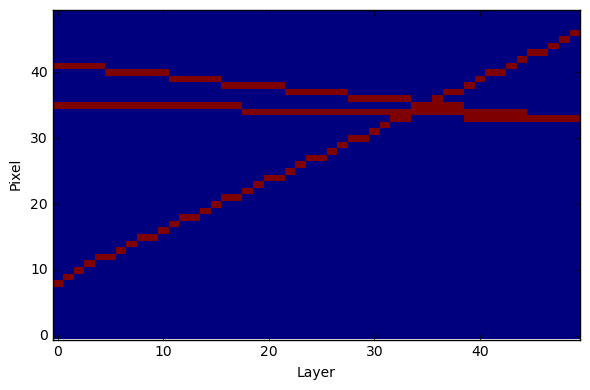

In [11]:
tracks, targets = gen_multi_tracks().next()
draw_event(tracks[0,0])
print targets[0]

### Generate a fixed dataset of multi-track events

In [15]:
epoch_size = 512000
gen_single = gen_tracks(batch_size=max_tracks, det_shape=det_shape)

train_events = np.zeros((epoch_size, 1, det_depth, det_width))
train_targets = -99 * np.ones((epoch_size, max_tracks, 2))
train_weights = np.zeros((epoch_size, max_tracks))
for n in range(epoch_size):
    num_tracks = min( max_tracks, np.random.poisson(mean_tracks) )
    tracks,targets = gen_single.next()
    train_events[n,0] = np.clip( sum( tracks[:num_tracks] ), 0, 1)
    event_targets = np.asarray(targets[:num_tracks])
    train_targets[n,:num_tracks] = event_targets[event_targets[:,0].argsort()] # sort by first column
    train_weights[n,:num_tracks] = np.ones((num_tracks))

[[  8.07455367  17.88022695]
 [ 11.55698913  14.17692511]
 [ 45.72336735 -21.01024342]
 [ 49.79383818 -23.31124236]
 [-99.         -99.        ]
 [-99.         -99.        ]]
[ 1.  1.  1.  1.  0.  0.]


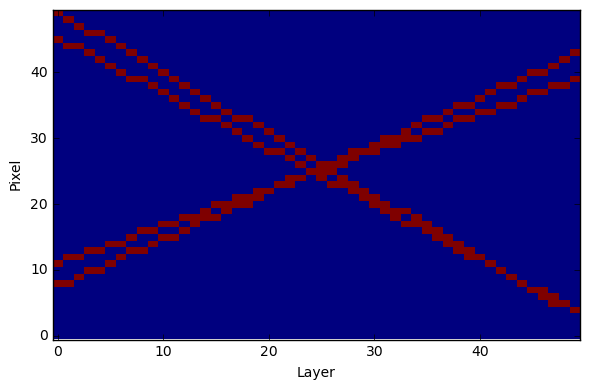

In [16]:
# Check the training data
test_index = np.random.randint(epoch_size)
draw_event(train_events[test_index,0])
print train_targets[test_index]
print train_weights[test_index]

### Build and train CNN + LSTM model

In [31]:
# Model
def build_model_1():
    """Test model.  Consists of several convolutional layers followed by dense layers and an LSTM"""
    input_layer = layers.Input(shape=(1, det_depth, det_width))
    layer = layers.Convolution2D(8, 3, 3, border_mode='same')(input_layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution2D(8, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.MaxPooling2D(pool_size=(2,2))(layer)
    layer = layers.Convolution2D(32, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution2D(32, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Flatten()(layer)
    layer = layers.Dense(400)(layer)
    layer = layers.RepeatVector(mean_tracks)(layer)
    layer = layers.LSTM(400, return_sequences=True)(layer)
    output_layer = layers.TimeDistributed(layers.Dense(2))(layer)
    model = models.Model(input=input_layer, output=output_layer)
    model.compile(loss='mean_squared_error', optimizer='Adam')
    return model

In [33]:
# Train the model
model_1 = build_model_1()
train_generator = gen_n_tracks()
%time model_1.fit_generator(train_generator, epoch_size, 10)

Epoch 1/10
512000/512000 [==============================] - 126s - loss: 26.9673   
Epoch 2/10
512000/512000 [==============================] - 126s - loss: 1.0135   
Epoch 3/10
512000/512000 [==============================] - 127s - loss: 0.7789   
Epoch 4/10
512000/512000 [==============================] - 127s - loss: 0.6997   
Epoch 5/10
512000/512000 [==============================] - 127s - loss: 0.6489   
Epoch 6/10
512000/512000 [==============================] - 126s - loss: 0.5969   
Epoch 7/10
512000/512000 [==============================] - 125s - loss: 0.5512   
Epoch 8/10
512000/512000 [==============================] - 127s - loss: 0.5391   
Epoch 9/10
512000/512000 [==============================] - 126s - loss: 0.5210   
Epoch 10/10
512000/512000 [==============================] - 125s - loss: 0.5096   
CPU times: user 19min 38s, sys: 13min 1s, total: 32min 40s
Wall time: 21min 16s


### Visualize model predictions

[[ 12.44626238  -4.06360878]
 [ 24.40380869   5.4338615 ]
 [ 46.99184292 -14.77915867]]
[[ 12.30691338  -4.33905554]
 [ 24.47769165   6.45440435]
 [ 46.9777565  -14.66608238]]


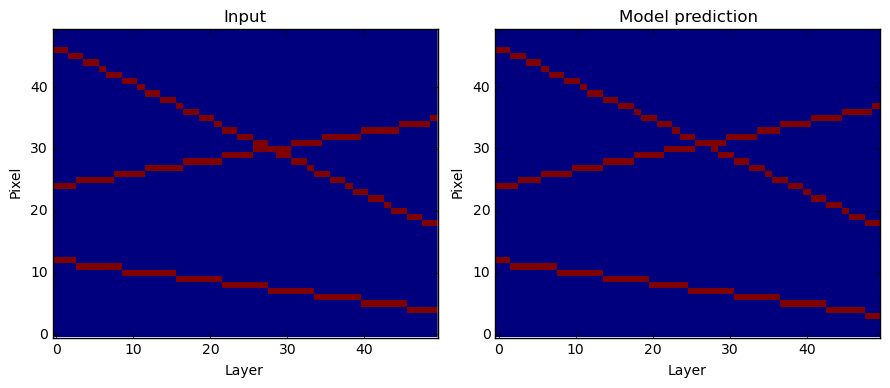

In [42]:
test_data = gen_n_tracks().next()
test_event = test_data[0][0]
test_target = test_data[1][0]
test_pred = model_1.predict(np.asarray([test_event]))[0]
print test_target
print test_pred
pred_event = np.clip(sum([ simulate_straight_track(line[1]/slope_scale, line[0], det_shape) for line in test_pred ]), 0, 1)
draw_input_and_pred(test_event[0], pred_event)

### Train on events with variable number of tracks

In [43]:
# Model
def build_model_2():
    """Test model.  Consists of several convolutional layers followed by dense layers and an LSTM"""
    input_layer = layers.Input(shape=(1, det_depth, det_width))
    layer = layers.Convolution2D(8, 3, 3, border_mode='same')(input_layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution2D(8, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.MaxPooling2D(pool_size=(2,2))(layer)
    layer = layers.Convolution2D(32, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution2D(32, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Flatten()(layer)
    layer = layers.Dense(400)(layer)
    layer = layers.RepeatVector(max_tracks)(layer)
    layer = layers.LSTM(400, return_sequences=True)(layer)
    output_layer = layers.TimeDistributed(layers.Dense(2))(layer)
    model = models.Model(input=input_layer, output=output_layer)
    model.compile(loss='mean_squared_error', optimizer='Adam', sample_weight_mode="temporal")
    return model

In [44]:
# Train the model
model_2 = build_model_2()
model_2.fit(train_events, train_targets, batch_size=batch_size, nb_epoch=10, 
           validation_split=0.1, sample_weight=train_weights)

Train on 460800 samples, validate on 51200 samples
Epoch 1/10
460800/460800 [==============================] - 119s - loss: 23.8822 - val_loss: 3.7573
Epoch 2/10
460800/460800 [==============================] - 120s - loss: 2.8856 - val_loss: 2.9094
Epoch 3/10
460800/460800 [==============================] - 119s - loss: 2.0346 - val_loss: 2.1316
Epoch 4/10
460800/460800 [==============================] - 120s - loss: 1.8304 - val_loss: 1.7432
Epoch 5/10
460800/460800 [==============================] - 120s - loss: 1.5603 - val_loss: 1.6232
Epoch 6/10
460800/460800 [==============================] - 120s - loss: 1.1889 - val_loss: 1.5654
Epoch 7/10
460800/460800 [==============================] - 120s - loss: 1.1257 - val_loss: 1.5782
Epoch 8/10
460800/460800 [==============================] - 120s - loss: 0.9432 - val_loss: 1.6396
Epoch 9/10
460800/460800 [==============================] - 120s - loss: 0.9524 - val_loss: 1.5339
Epoch 10/10
460800/460800 [==============================

### Visualize prediction

[[  6.3881758    2.65022966]
 [ 16.56138783  10.57189958]
 [ 22.02666699   6.50339801]
 [ 31.74159886 -11.97084678]
 [ 37.34763555 -13.28729689]]
[[  6.69193983   2.69062376]
 [ 16.30273628  10.37247658]
 [ 23.02808762   5.6978693 ]
 [ 31.67787743 -12.75119209]
 [ 37.52376938 -13.64584541]]


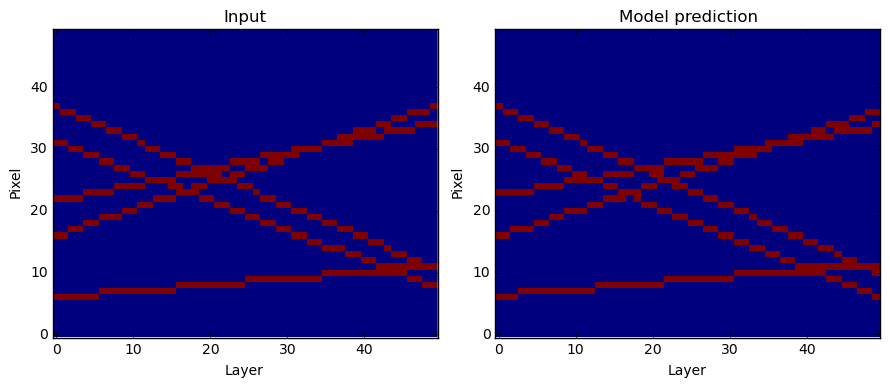

In [52]:
test_index = np.random.randint(epoch_size*0.9,epoch_size)
test_event = train_events[test_index]
test_weights = train_weights[test_index].astype(np.bool_)
test_target = train_targets[test_index][test_weights]
test_pred = model_2.predict(np.asarray([test_event]))[0][test_weights]
print test_target
print test_pred
pred_event = np.clip(sum([ simulate_straight_track(line[1]/slope_scale, line[0], det_shape) for line in test_pred ]), 0, 1)
draw_input_and_pred(test_event[0], pred_event)